# Dataset Loading

We can load in either the generated data (under iks_npy_files) or use the test files from the authors themselves

In [23]:
import numpy as np

#An example of loading a specific file 

# Path to the .npy file
file_path = "./testing_data/results_new_new/0.2_0.2_0.1_0.0_3_0_100.0.npy"
# Load the .npy file
data = np.load(file_path, allow_pickle=True)

In [24]:
!pip install einops
!pip install torch
!pip install glob2

Validation Set Inspection:
Batch 0 inspection:
Inputs: torch.Size([1, 2, 64, 64])
Target: torch.Size([1, 1, 64, 64])
Target_n: torch.Size([1, 1, 64, 64])
Max Values: tensor([[2578.1741]], dtype=torch.float64)
Min Values: tensor([[0.]])
Stack: torch.Size([1, 2])
Feature Shape (f_s): torch.Size([1, 4])


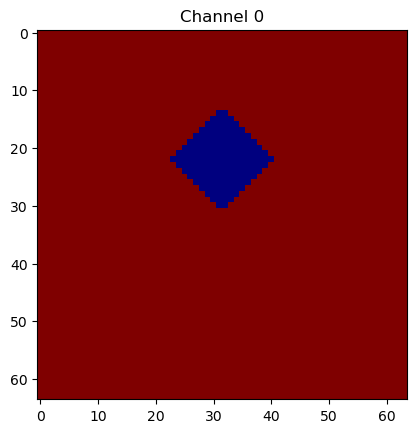

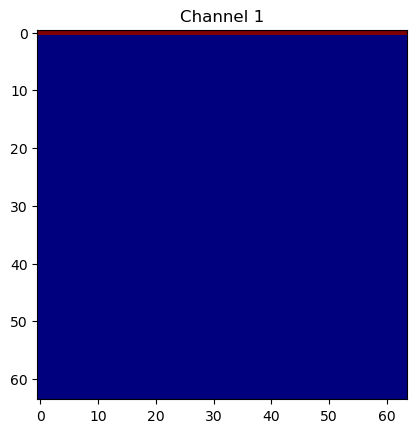


Test Set Inspection:
Batch 0 inspection:
Inputs: torch.Size([1, 2, 64, 64])
Target: torch.Size([1, 1, 64, 64])
Target_n: torch.Size([1, 1, 64, 64])
Max Values: tensor([[1453.1319]], dtype=torch.float64)
Min Values: tensor([[0.]])
Stack: torch.Size([1, 2])
Feature Shape (f_s): torch.Size([1, 4])


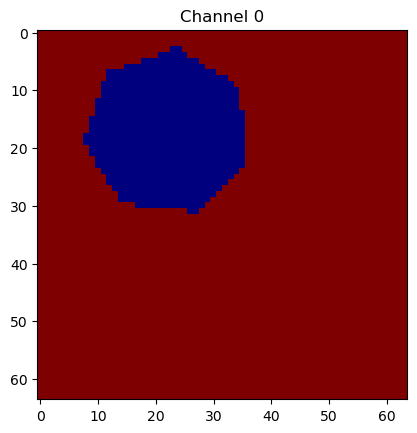

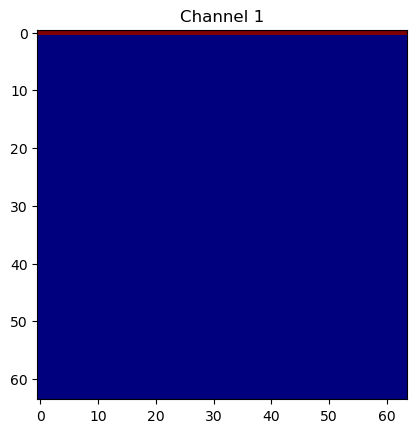

In [16]:
# Split test_list into validation and test subsets
from sklearn.model_selection import train_test_split
from base_network.dataset import DataSet_hyper
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob2

batch_size = 1

test_list = np.load("./revsion/network_hyperelastic/test_list_nn_90.npy",allow_pickle=True)
test_list = [i.replace("./","./testing_data/") for i in test_list]
# Split the test_list for validation and test sets
test_list, val_list = train_test_split(test_list, test_size=0.5, random_state=42)

# Create datasets and loaders for validation and test
val_dataset = DataSet_hyper(val_list)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

test_dataset = DataSet_hyper(test_list)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

def inspect_batch(loader, num_batches=1):
    with torch.no_grad():
        for i, (inps, target, target_n, maxx, minn, stack, f_s) in enumerate(loader):
            if i >= num_batches:
                break
            print(f"Batch {i} inspection:")
            print("Inputs:", inps.shape)
            print("Target:", target.shape)
            print("Target_n:", target_n.shape)
            print("Max Values:", maxx)
            print("Min Values:", minn)
            print("Stack:", stack.shape)
            print("Feature Shape (f_s):", f_s.shape)
            
            load = inps[0, 1].detach().cpu().numpy()  # Extract the second channel of the input (load)
            geo = inps[0, 0].detach().cpu().numpy()  # Extract the first channel of the target
            
            # Plot and save the input geometry
            plt.imshow(load, cmap="Blues")
            plt.axis("off")
            plt.savefig("./images/bc.png", bbox_inches="tight", pad_inches=0)
            plt.close()
            
            # Plot and save the target result
            plt.imshow(geo, cmap="jet")
            plt.axis("off")
            plt.savefig("./images/res_hyp.png", bbox_inches="tight", pad_inches=0)
            plt.close()
            
            # Assuming `target` is the tensor with dimensions [1, 1, 64, 64]
            target_tensor = target[0, 0]  # Remove batch and channel dimensions to get [64, 64]
            
            # Convert to NumPy for plotting
            target_array = target_tensor.detach().cpu().numpy()
            
            # Plot and save the target result
            plt.imshow(target_array, cmap="jet")  
            plt.axis("off")  
            plt.savefig("./images/target_plot.png", bbox_inches="tight", pad_inches=0)  # Save the image
            plt.close()

            for i in range(inps.shape[1]):  # Loop through channels
                channel_data = inps[0, i].detach().cpu().numpy()
                plt.imshow(channel_data, cmap="jet")
                plt.title(f"Channel {i}")
                plt.show()
            break

# Inspect validation set
print("Validation Set Inspection:")
inspect_batch(val_loader)

# Inspect test set
print("\nTest Set Inspection:")
inspect_batch(test_loader)

In [17]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

batch = next(iter(test_loader))  # Load one batch

# Unpack the batch
inps, target, target_n, maxx, minn, stack, f_s = batch

print("\nTest Set Inspection:")
print("Inputs shape:", inps.shape)
print("Target shape:", target.shape)
print("\nTest Set Inspection:")
print(inps.shape)


Test Set Inspection:
Inputs shape: torch.Size([1, 2, 64, 64])
Target shape: torch.Size([1, 1, 64, 64])

Test Set Inspection:
torch.Size([1, 2, 64, 64])


In [ ]:
#Investigation into the shape of the data

for i in range(inps.shape[1]):  # Loop through channels
    channel_data = inps[0, i].detach().cpu().numpy()
    plt.imshow(channel_data, cmap="jet")
    plt.title(f"Channel {i}")
    plt.show()

for i in range(target.shape[1]):  # Loop through channels
    channel_data = target[0, i].detach().cpu().numpy()
    plt.imshow(channel_data, cmap="jet")
    plt.title(f"Channel {i}")
    plt.show()


channel_data = inps[0, 0].detach().cpu().numpy()
print("input: ", channel_data)

channel_data_t = target[0, 0].detach().cpu().numpy()
print("target: ", channel_data_t)

# Symmetry

First we find the center of the origin for the image. 

In [18]:
import numpy as np
from scipy.ndimage import center_of_mass, shift
import matplotlib.pyplot as plt

# Input and target data
origin_data = inps[0, 0].detach().cpu().numpy()
origin_data_t = target[0, 0].detach().cpu().numpy()

print("Input: ", origin_data)
print("Target: ", origin_data_t)

# Getting center of mass of the polygon in the input
polygon_center = center_of_mass(origin_data == 0)  # 0 represents the polygon

# Finding the center and the offset to center the polygon
grid_center = (origin_data.shape[0] // 2, origin_data.shape[1] // 2)
offset = (grid_center[0] - polygon_center[0], grid_center[1] - polygon_center[1])

# Add the translation to the origin data.
centered_channel_data = shift(origin_data, shift=offset, order=1, mode='constant', cval=1)

# Inverting the data for a cleaner look
channel_data = 1 - centered_channel_data
channel_data_t = origin_data_t

Input:  [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Target:  [[356.85979933 322.35151772 303.10120405 ... 298.86102769 322.24885027
  357.72772721]
 [355.7611742  331.30252327 308.99821254 ... 291.1116673  308.50980111
  331.19518369]
 [341.79532684 321.27465537 303.20649484 ... 289.26944636 304.56573527
  322.71503529]
 ...
 [131.34388946 132.7050684  133.53047008 ... 133.14074589 132.46245211
  131.3459838 ]
 [131.85471074 132.35939828 132.71310403 ... 132.48055141 132.22617311
  131.72604579]
 [132.03061003 132.31891128 132.28632694 ... 132.09833913 132.08496761
  132.01507649]]


-27 -0.008282140747048184
opt image:  -0.019122657023574872
opt target_old:  -17.017296560387962
opt target:  -48.60336572360325


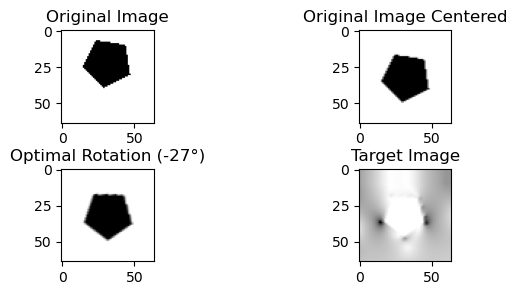

In [8]:
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

def symmetry_score(image):
    """
    Compute symmetry score by comparing the two halves of the image.
    """
    # Assert to ensure the image is 2D
    assert len(image.shape) == 2, "Symmetry score expects a 2D image."

    # We split the image in have across the vertical cut
    center_x = image.shape[1] // 2
    left_half = image[:, :center_x]
    right_half = np.flip(image[:, center_x:], axis=1) #Flip it to compare later

    # Padding for rectangle images
    if left_half.shape[1] != right_half.shape[1]:
        min_width = min(left_half.shape[1], right_half.shape[1])
        left_half = left_half[:, :min_width]
        right_half = right_half[:, :min_width]

    score = -np.mean(np.abs(left_half - right_half))  # Negated for maximization
    return score

def find_optimal_rotation(image, angle_range=(-90, 90), step=1):
    """
    Find the optimal rotation angle for maximum symmetry. This a bit computationally expensive because we literally rotate the polygon 360.
    Not as expensive as a FEA at least?
    """
    best_angle = None
    best_score = float('-inf')
    scores = [] 

    # Iterate through the angle range
    for angle in range(angle_range[0], angle_range[1] + 1, step):
        # Rotate the image
        rotated_image = rotate(image, angle, reshape=False, order=1)

        # Compute symmetry score
        score = symmetry_score(rotated_image)
        scores.append((angle, score))

        # Check if this score is the best so far
        if score > best_score:
            best_score = score
            best_angle = angle

    # for angle, score in scores:
    #     print(f"Angle: {angle}, Symmetry Score: {score}")

    return best_angle, best_score
    
best_angle, best_score = find_optimal_rotation(channel_data, angle_range=(-90, 90), step=1)

print(best_angle, best_score)

# Rotate the image to the best angle
optimal_image = rotate(channel_data, 8, reshape=False, order=1, mode='nearest')
rotate_channel_data_t = rotate(channel_data_t, 8, reshape=False, order=1, mode='nearest')
optimal_target = shift(rotate_channel_data_t, shift=offset, order=1, mode='nearest')

plt.subplot(3, 2, 1)
plt.imshow(origin_data, cmap='gray')
plt.title("Original Image")

plt.subplot(3, 2, 2)
plt.imshow(1-channel_data, cmap='gray')
plt.title("Original Image Centered")

plt.subplot(3, 2, 3)
plt.imshow(1-optimal_image, cmap='gray')
plt.title(f"Optimal Rotation ({best_angle}°)")

plt.subplot(3, 2, 4)
plt.imshow(1 - optimal_target, cmap='gray')
plt.title("Target Image")

print("opt image: ", symmetry_score(optimal_image))
print("opt target_old: ", symmetry_score(origin_data_t))
print("opt target: ", symmetry_score(optimal_target))

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

# Boundary Conditions

We load in the data generated from the systematic testing part

In [11]:
!ls ika_npy_files/

batch_0.npy batch_1.npy batch_2.npy batch_3.npy batch_4.npy


Keys in ika_data: dict_keys(['inps', 'target', 'target_n', 'stack', 'pred', 'pred_min_max'])


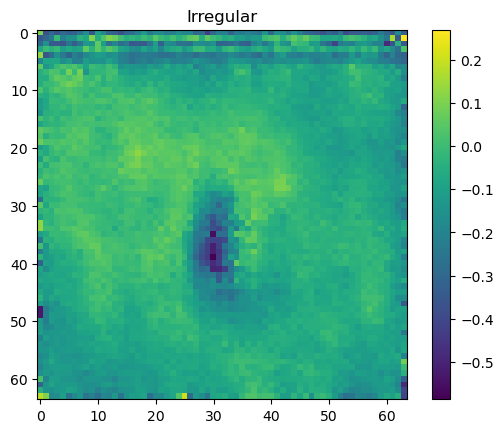

In [19]:
systematic_file_path = "ika_npy_files/batch_4.npy" 
ika_data = np.load(systematic_file_path, allow_pickle=True).item()

print("Keys in ika_data:", ika_data.keys())

pred = ika_data['pred'][0, 0]
plt.imshow(pred, cmap='viridis')
plt.title("Irregular")
plt.colorbar()
plt.show()

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

def normalize_stress_field(stress_field):
    """
    Normalize the stress field
    """
    return (stress_field - np.min(stress_field)) / (np.max(stress_field) - np.min(stress_field))

def detect_column_oscillations_with_sign(stress_field, gradient_threshold_in=0.2, window_size=5):
    """
    Find oscillatory patterns in stress field (for both vertical and horizontal).

    Input:
    stress_field (ndarray): 2D stress field.
    gradient_threshold (float): Threshold for gradient changes
    window_size (int): Height/width of the sliding windows.

    Returns:
    vertical_mask, horizontal_mask, combined_mask (all bitmasks)
    """
    normalized_stress_field = normalize_stress_field(stress_field)
    
    def count_strict_alternations(window, gradient_threshold=gradient_threshold_in):
        differences = np.diff(window)
        significant_differences = differences[np.abs(differences) > gradient_threshold]
        significant_signs = np.sign(significant_differences)

        pattern_length = 5 
        for i in range(len(significant_signs) - pattern_length + 1):
            if (
                list(significant_signs[i:i + pattern_length - 1]) == [1, -1, 1, -1]
                or list(significant_signs[i:i + pattern_length - 1]) == [-1, 1, -1, 1]
            ):
                return 1 
    
        return 0

    # Apply the masks 
    vertical_mask = generic_filter(
        normalized_stress_field,
        count_strict_alternations,
        size=(window_size, 1), 
        mode='constant',
        cval=0
    ) > 0  
    horizontal_mask = generic_filter(
        normalized_stress_field,
        count_strict_alternations,
        size=(1, window_size),  
        mode='constant',
        cval=0
    ) > 0  

    combined_mask = np.logical_or(vertical_mask, horizontal_mask)

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(normalized_stress_field, cmap='gray')
    plt.title("Original Stress Field")
    plt.axis("off")

    # Vertical 
    plt.subplot(1, 3, 2)
    plt.imshow(normalized_stress_field, cmap='gray')
    plt.imshow(vertical_mask, cmap='Blues', alpha=0.5)
    plt.title("Vertical Oscillations")
    plt.axis("off")

    # Horizontal 
    plt.subplot(1, 3, 3)
    plt.imshow(normalized_stress_field, cmap='gray')
    plt.imshow(horizontal_mask, cmap='Greens', alpha=0.5)
    plt.title("Horizontal Oscillations")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    return vertical_mask, horizontal_mask, combined_mask


[[0.80178034 0.2476139  0.34232318 ... 0.26720935 0.4860078  0.31284302]
 [0.2661612  0.33564082 0.400978   ... 0.87062716 0.28435108 1.        ]
 [0.33611393 0.5151711  0.27845916 ... 0.25928274 0.634203   0.27878356]
 ...
 [0.324628   0.5306672  0.58584166 ... 0.52654266 0.46023443 0.12377314]
 [0.63279796 0.5188464  0.5017908  ... 0.56012946 0.49363673 0.22226839]
 [0.8974879  0.812269   0.48024067 ... 0.5726365  0.63045245 0.20070991]]


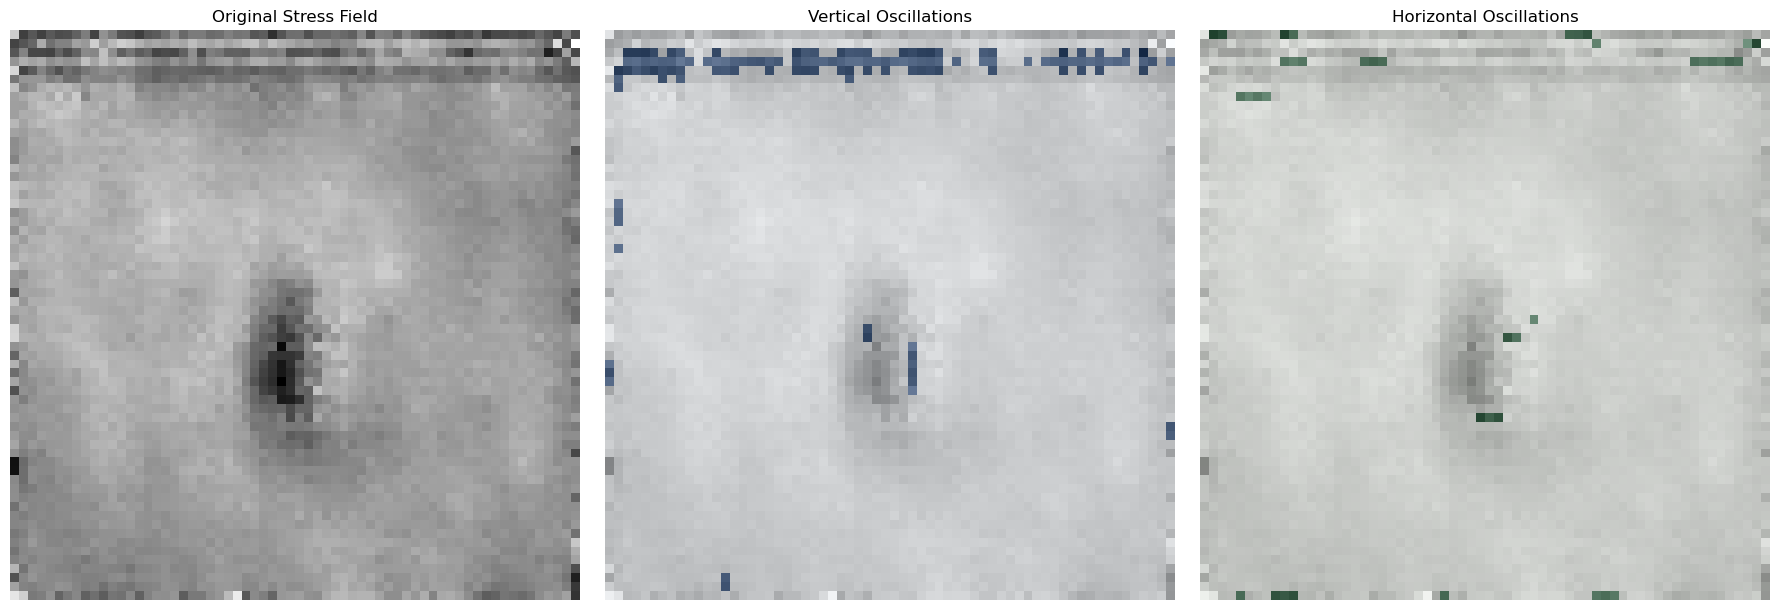

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False,  True,  True, ..., False, False, False],
        [False, False, False, ...,  True,  True, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False,  True,  True, ..., False, False, False],
        [False, False, False, ...,  True,  True, False],
        [False, False,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [98]:
detect_column_oscillations_with_sign(pred, gradient_threshold_in=0.05, window_size=7)

[[0.60165417 0.64017415 0.66166237 ... 0.66639548 0.64028875 0.60068535]
 [0.60288052 0.63018256 0.65507981 ... 0.67504572 0.655625   0.63030238]
 [0.61846994 0.6413762  0.66154484 ... 0.67710211 0.66002758 0.63976837]
 ...
 [0.85338699 0.85186757 0.85094621 ... 0.85138124 0.85213839 0.85338465]
 [0.85281678 0.85225342 0.8518586  ... 0.85211819 0.85240214 0.8529604 ]
 [0.85262043 0.85229862 0.85233499 ... 0.85254483 0.85255976 0.85263777]]


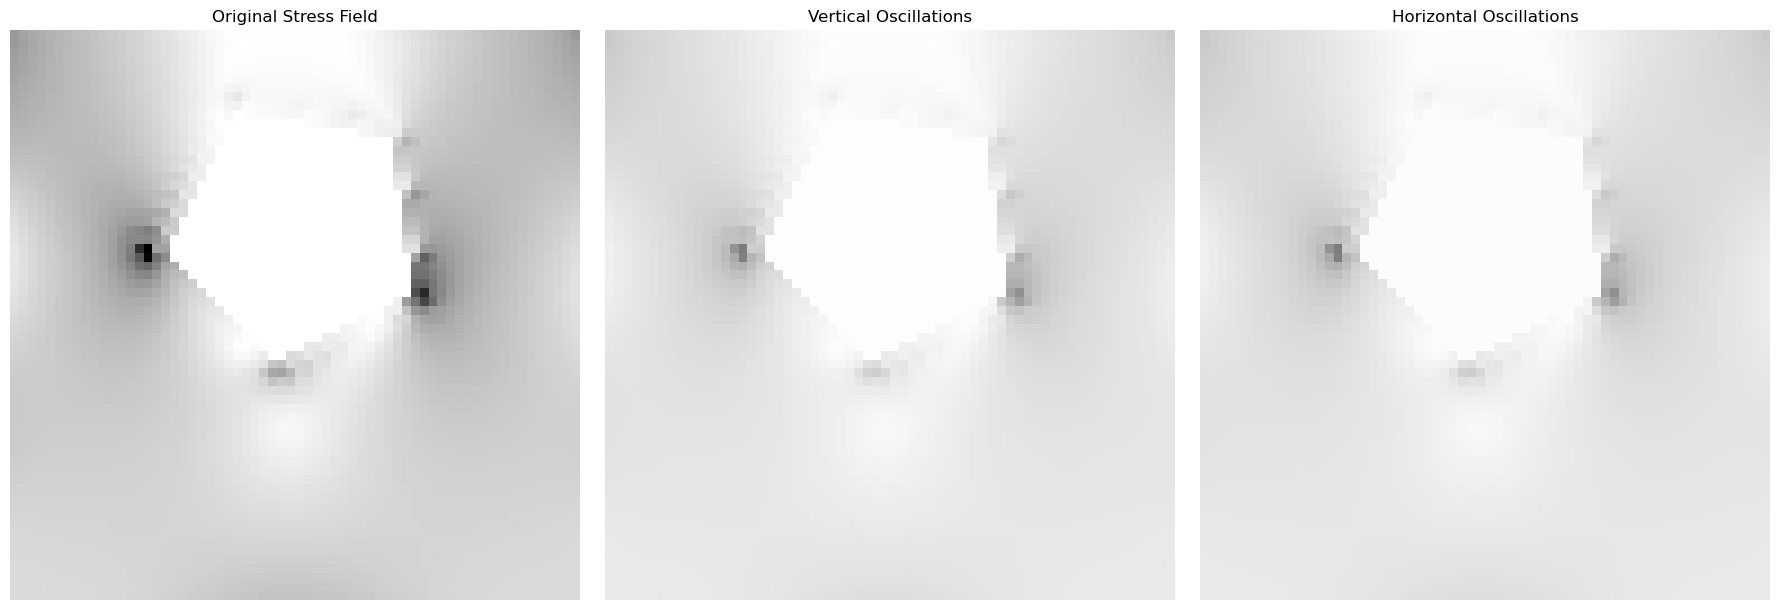

(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [97]:
detect_column_oscillations_with_sign(1-channel_data_t, gradient_threshold_in=0.05, window_size=6)

# Physical Constraints

In [22]:
#TODO

# Extra exploring

What hasnt worked: Laplacian detection for oscillation + sum of gradients as a physics law. 

In [21]:
import numpy as np

def sum_of_gradients(stress_field):
    """
    Compute the sum of all gradients in a normalized stress field.

    Parameters:
        stress_field (ndarray): 2D NumPy array representing the stress field.

    Returns:
        float: The sum of absolute gradients in the normalized stress field.
    """
    # Step 1: Normalize the stress field
    normalized_stress_field = (stress_field - np.min(stress_field)) / (np.max(stress_field) - np.min(stress_field))
    
    # Step 2: Compute gradients along both axes
    grad_vertical = np.gradient(normalized_stress_field, axis=0)  # Vertical gradients
    grad_horizontal = np.gradient(normalized_stress_field, axis=1)  # Horizontal gradients
    
    # Step 3: Compute the sum of absolute gradients
    print(np.sum(grad_vertical))
    print(np.sum(grad_horizontal))
    total_gradient_sum = np.sum(grad_vertical) + np.sum(grad_horizontal)
    
    return total_gradient_sum


In [103]:
sum_of_gradients(channel_data_t)

1.6694332122626516
-0.4096800059514448


1.2597532063112067

In [104]:
sum_of_gradients(pred)

18.741978
-6.495089


12.246889